In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# **Data Preparation**

<Axes: xlabel='Year', ylabel='Annual Max'>

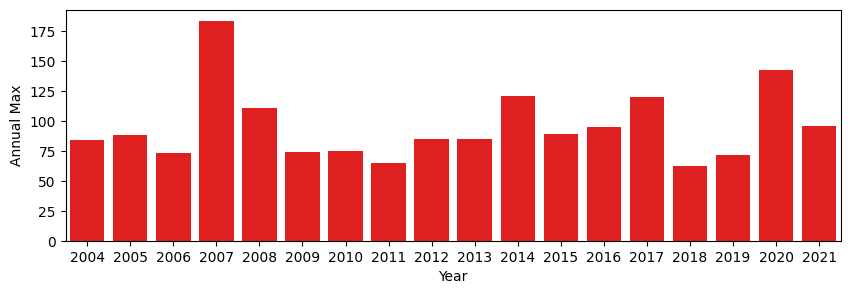

In [4]:
annual_max = [83.9, 88.3, 73, 183.7, 111.2, 74.4, 75.1, 64.6, 85.2, 84.9, 121, 88.9, 94.7, 120.4, 62.3, 71.5, 142.3, 95.9]
year = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

df = pd.DataFrame({'Year': year, 'Annual Max': annual_max})

plt.figure(figsize=(10,3))
sns.barplot(data=df,x='Year',y='Annual Max',color='red')

# **Probability Distribution Analysis**

In [8]:
return_periods = np.array([2,5,10,25,50,100,200,500,1000]) # State return period
probability = 1 - (1/return_periods)
def probability_distribution_analysis(df):
  # Normal Distribution
  avg_rain, std_rain = np.mean(df['Annual Max']), np.std(df['Annual Max'])
  norm_values = stats.norm.ppf(probability, loc=avg_rain, scale=std_rain)
  # Log Normal Distribution
  log_df = np.log(df['Annual Max'])
  log_avg_rain, log_std_rain = np.mean(log_df), np.std(log_df)
  log_norm_values = np.exp(stats.norm.ppf(probability, loc=log_avg_rain, scale=log_std_rain))
  # Pearson III Distribution
  skewness = stats.skew(df['Annual Max'])
  pearson3_values = stats.pearson3.ppf(probability, skew=skewness, loc=avg_rain, scale=std_rain)
  # Log Pearson III Distribution
  skewness_log = stats.skew(log_df)
  log_pearson3_values = np.exp(stats.pearson3.ppf(probability, skew=skewness, loc=log_avg_rain, scale=log_std_rain))
  # Gumbel Distribution
  gumbel_values1 = stats.gumbel_r.ppf(probability, loc=avg_rain, scale=std_rain) # Gumbel in General Statistics
  gumbel_values2 = avg_rain + (std_rain * 0.7797) * ((-np.log(-np.log(1 - 1 / return_periods)) - 0.5772)) # Gumbel calculated based on the Gumbel formula for hydrology

  # Visualization
  plt.figure(figsize=(10,6))
  plt.plot(return_periods, norm_values,'o-', label='Normal')
  plt.plot(return_periods, log_norm_values, 's-',label='Log Normal')
  plt.plot(return_periods, pearson3_values, 'd-',label='Pearson III')
  plt.plot(return_periods, log_pearson3_values, '^-',label='Log Pearson III')
  plt.plot(return_periods, gumbel_values1, 'x-',label='Gumbel 1')
  plt.plot(return_periods, gumbel_values2, 'x-', label ='Gumbel 2')
  plt.xlabel('Return Period (year)')
  plt.ylabel('Annual Maximum Rainfall (mm)')
  plt.xlim(0,1000)
  plt.ylim(50,400)
  plt.grid(True)
  plt.legend()
  plt.show()

  # DataFrame
  result = pd.DataFrame({
    'Return Period (y)': return_periods,
    'Normal': norm_values,
    'Log-Normal': log_norm_values,
    'Pearson III': pearson3_values,
    'Log-Pearson III': log_pearson3_values,
    'Gumbel 1': gumbel_values1,
    'Gumbel 2': gumbel_values2
  })
  result = result.round(1)
  return norm_values, log_norm_values, pearson3_values, log_pearson3_values, gumbel_values1, gumbel_values2, result

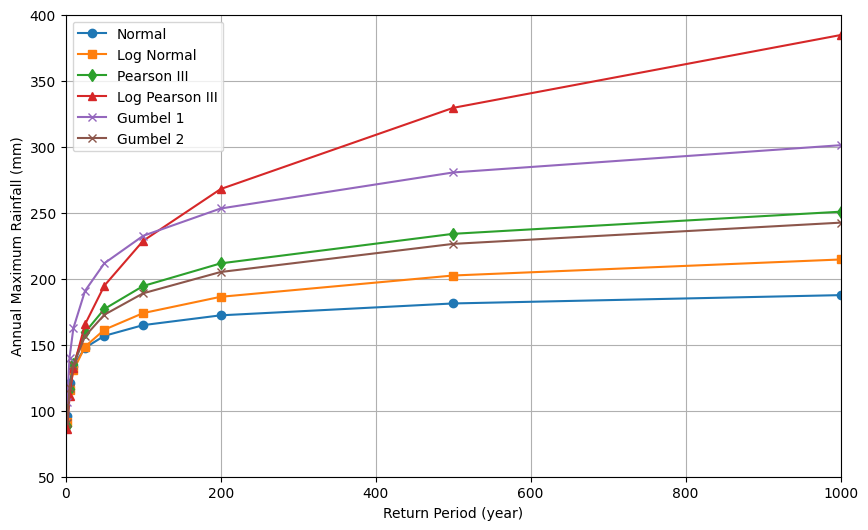

In [9]:
norm_values , log_norm_values , pearson3_values , log_pearson3_values , gumbel_values1, gumbel_values2, result = probability_distribution_analysis(df)

In [10]:
result

,Return Period (y),Normal,Log-Normal,Pearson III,Log-Pearson III,Gumbel 1,Gumbel 2
0,2,95.6,91.8,88.5,86.0,106.5,90.7
1,5,120.7,115.7,116.2,111.1,140.3,117.0
2,10,133.8,130.6,135.3,132.4,162.6,134.4
3,25,147.7,148.5,159.4,165.4,190.8,156.4
4,50,156.7,161.4,177.1,194.8,211.7,172.8
5,100,164.8,174.0,194.5,228.7,232.5,189.0
6,200,172.3,186.3,211.6,267.9,253.2,205.1
7,500,181.3,202.4,234.0,329.4,280.5,226.4
8,1000,187.6,214.6,250.8,384.6,301.1,242.5


# **Selection of Rainfall Distribution**

In [25]:
def based_distribution (df):
  df_temp = df.copy()
  df_temp = df_temp.drop(columns=['Year'])
  df_temp = df_temp.sort_values(by='Annual Max',ascending=False).reset_index(drop=True)
  df_temp['rank'] = range(1,len(df_temp)+1)
  df_temp['p'] = round(1-df_temp['rank']/(len(df_temp)+1),4)
  df_temp['T'] = ((len(df_temp) + 1) / df_temp['rank']).round(2)

  avg_rain, std_rain, log_avg, log_std_rain, skewness, skewness_log= (
      np.mean(df_temp['Annual Max']), np.std(df_temp['Annual Max']),
      np.mean(np.log(df_temp['Annual Max'])), np.std(np.log(df_temp['Annual Max'])),
      stats.skew(df_temp['Annual Max']), stats.skew(np.log(df_temp['Annual Max']))
  )

  df_temp['Normal'] = stats.norm.ppf(df_temp['p'], loc=avg_rain, scale=std_rain).round(1)
  df_temp['Log Normal'] = np.exp(stats.norm.ppf(df_temp['p'], loc=log_avg, scale=log_std_rain)).round(1)
  df_temp['Pearson 3'] = stats.pearson3.ppf(df_temp['p'], skew=skewness, loc=avg_rain, scale=std_rain).round(1)
  df_temp['Log Pearson 3'] = np.exp(stats.pearson3.ppf(df_temp['p'], skew=skewness_log, loc = log_avg, scale = log_std_rain)).round(1)
  df_temp['Gumbel 1'] = stats.gumbel_r.ppf(df_temp['p'], loc=avg_rain, scale=std_rain).round(1)
  df_temp['Gumbel 2'] = (avg_rain + (std_rain * 0.7797) * ((-np.log(-np.log(1 - 1/df_temp['T'])) - 0.5772))).round(1)

  # Histogram of Distribution
  print('Graph of Distribution\n')
  bins_number = 10
  distributions = ['Annual Max', 'Normal', 'Log Normal', 'Pearson 3', 'Log Pearson 3', 'Gumbel 1', 'Gumbel 2']
  markers = ['o','s','^','v','D','p','*']
  linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]

  # X Scale
  x_min = min([df_temp[dist].min() for dist in distributions])
  x_max = max([df_temp[dist].max() for dist in distributions])

  # Y Scale
  max_counts = []
  for dist in distributions:
      counts, _ = np.histogram(df_temp[dist], bins=bins_number)
      max_counts.append(counts.max())
  y_max = max(max_counts)

  # Plot per figure
  for dist in distributions:
      plt.figure(figsize=(8, 4))
      sns.histplot(df_temp[dist], bins=bins_number, kde=True, color='skyblue', edgecolor='black')
      plt.title(f'Distribution: {dist}')
      plt.xlabel('Value')
      plt.ylabel('Frequency')
      plt.xlim(x_min, x_max)
      plt.ylim(0, y_max)
      plt.tight_layout()
      plt.show()

  # Rainfall Frequency Analysis: Probability Plot
  print('\nRainfall Frequency Analysis: Probability Plot\n')
  plt.figure(figsize=(10, 6))
  for dist, marker, ls in zip(distributions, markers, linestyles):
        plt.plot(df_temp[dist], df_temp['p'], label=dist, marker=marker, linestyle=ls, linewidth=1.5, markersize=6)
  plt.xlabel('Rainfall (mm)')
  plt.ylabel('Exceedance Probability (1 - P)')
  plt.title('Rainfall Frequency Analysis: Probability Plot')
  plt.xlim(40,200)
  plt.ylim(0,1)
  plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
  plt.legend()
  plt.show()

  print('\n\n Based Distribution Data Frame\n')
  return df_temp

Graph of Distribution



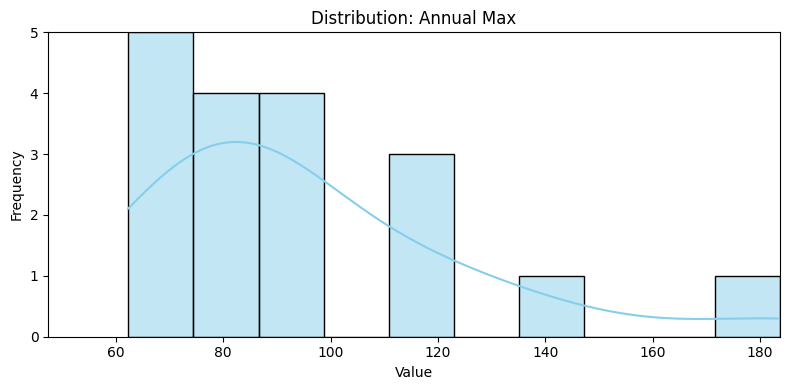

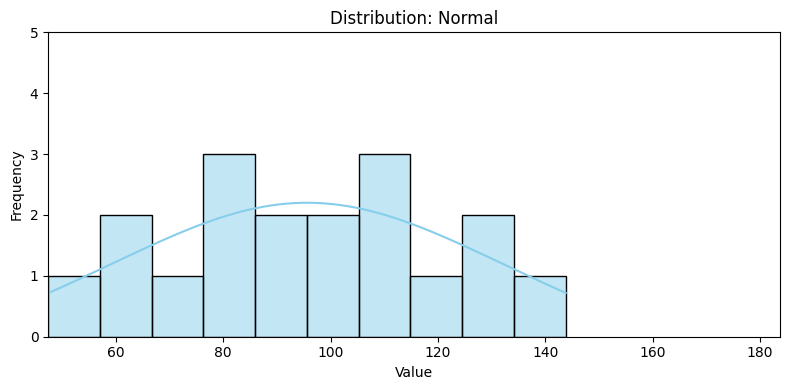

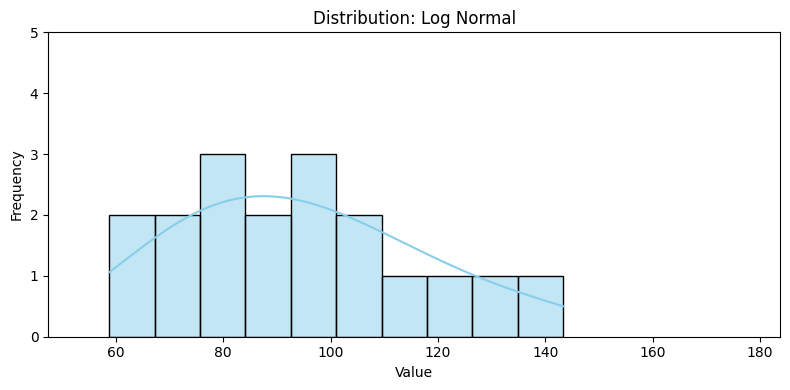

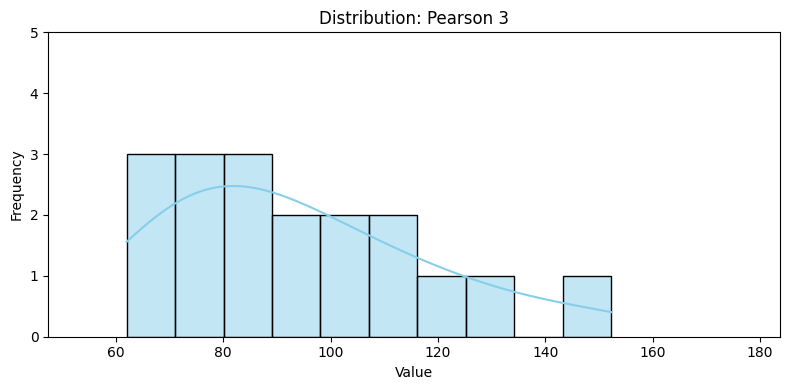

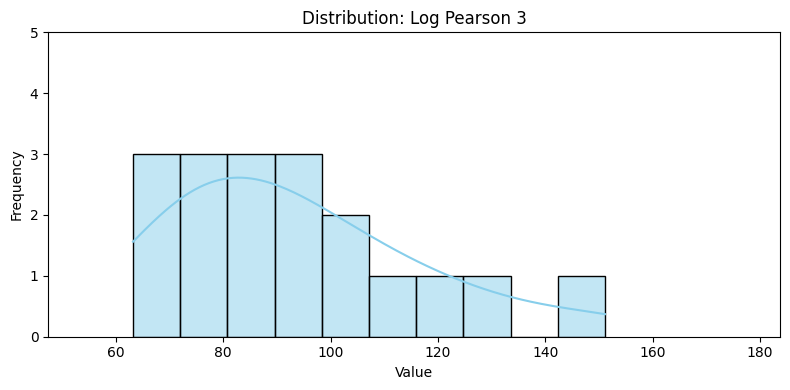

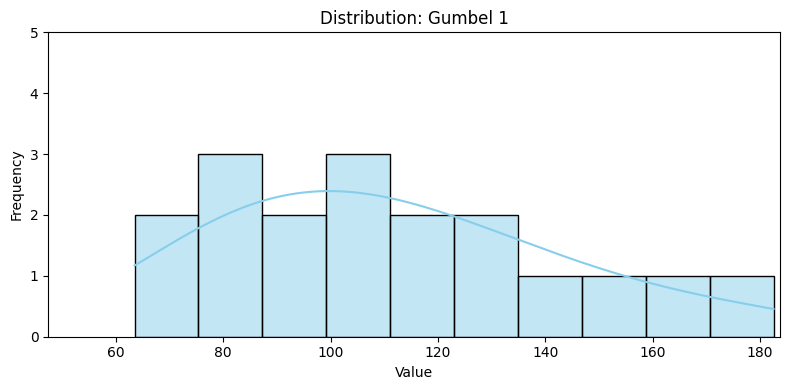

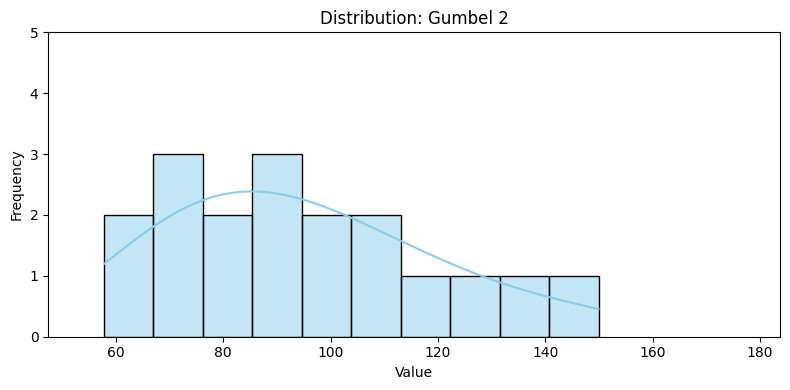


Rainfall Frequency Analysis: Probability Plot



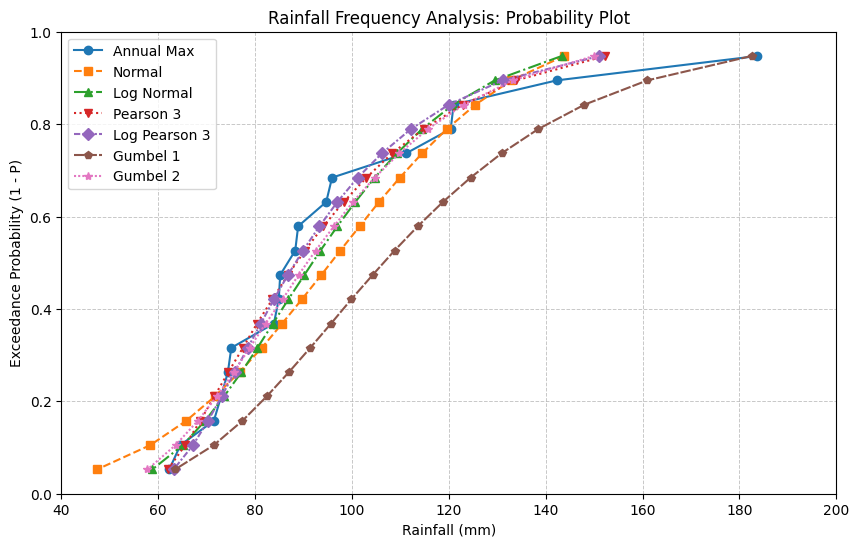



 Based Distribution Data Frame



In [196]:
based_distribution = based_distribution(df)

# Chi Square

In [216]:
def chi_square_test (based_distribution):
  from scipy.stats import chi2
  df_chisq = based_distribution.copy()
  df_chisq = df_chisq.drop(columns=['rank','p','T'])

  distribution_columns = ['Annual Max', 'Normal', 'Log Normal', 'Pearson 3', 'Log Pearson 3', 'Gumbel 1', 'Gumbel 2']

  # Determine the number of classes
  n_class = max(4 , int(1 + 3.3 * np.log10(len(df_chisq['Annual Max']))))

  # Defining class boundaries
  min_edge = min(df_chisq['Annual Max'].min(),df_chisq['Normal'].min())
  max_edge = max(df_chisq['Annual Max'])

  edge_class = np.linspace(min_edge, max_edge, n_class+1)
  df_chisq['Class'] = pd.cut(df_chisq['Annual Max'], bins=edge_class, include_lowest=True)


  for dist in distribution_columns[1:]: # Skip Annual Max
    df_chisq[f'Class_{dist}'] = pd.cut(df_chisq[dist], bins=edge_class, include_lowest=True)

  # Observed & Expected frequency
  freq_observed = df_chisq['Class'].value_counts().sort_index()

  chi_square_results = {}

  for dist in distribution_columns[1:]:
      freq_expected = df_chisq[f'Class_{dist}'].value_counts().sort_index().replace(0, np.nan)  # Avoid zero division

      # Chi-square per class
      chi_square_per_class = ((freq_observed - freq_expected) ** 2) / freq_expected

      # Total Chi-square
      chi_square_total = chi_square_per_class.sum().round(3)

      # Degree of freedom
      dof = n_class - 2

      # Critical Value
      alpha = 0.05
      X2_crit = chi2.ppf(1 - alpha, df=dof).round(3)

      # Save to dictionary
      chi_square_results[dist] = {
          'Chi-Square Total': chi_square_total,
          'Chi-Square Critical': X2_crit,
          'Chi-Square per Class': chi_square_per_class
      }

  # --- print result ---
  for dist, result in chi_square_results.items():
      print(f"\nDistribusi: {dist}")
      print(f"  Chi-Square Total: {result['Chi-Square Total']:.3f}")
      print(f"  Chi-square Critical (α=0.05: {result['Chi-Square Critical']:.3f}")
      print(f"  Chi-Square per Class:\n{result['Chi-Square per Class']}")

  result_chisquare = pd.DataFrame.from_dict({k: v['Chi-Square Total'] for k, v in chi_square_results.items()}, orient='index', columns=['Chi-Square Total'])
  result_chisquare['Chi-Square Critical'] = [v['Chi-Square Critical'] for v in chi_square_results.values()]
  result_chisquare['Result'] = result_chisquare.apply(
      lambda row: 'Accepted' if row['Chi-Square Total'] < row['Chi-Square Critical'] else 'Rejected',
      axis=1
  )
  return result_chisquare

In [217]:
chi_square_test(based_distribution)


Distribusi: Normal
  Chi-Square Total: 1.693
  Chi-square Critical (α=0.05: 7.815
  Chi-Square per Class:
Class
(47.399, 74.66]     0.250000
(74.66, 101.92]     0.142857
(101.92, 129.18]    0.800000
(129.18, 156.44]    0.500000
(156.44, 183.7]          NaN
Name: count, dtype: float64

Distribusi: Log Normal
  Chi-Square Total: 1.000
  Chi-square Critical (α=0.05: 7.815
  Chi-Square per Class:
Class
(47.399, 74.66]     0.25
(74.66, 101.92]     0.00
(101.92, 129.18]    0.25
(129.18, 156.44]    0.50
(156.44, 183.7]      NaN
Name: count, dtype: float64

Distribusi: Pearson 3
  Chi-Square Total: 0.893
  Chi-square Critical (α=0.05: 7.815
  Chi-Square per Class:
Class
(47.399, 74.66]     0.000000
(74.66, 101.92]     0.142857
(101.92, 129.18]    0.250000
(129.18, 156.44]    0.500000
(156.44, 183.7]          NaN
Name: count, dtype: float64

Distribusi: Log Pearson 3
  Chi-Square Total: 0.861
  Chi-square Critical (α=0.05: 7.815
  Chi-Square per Class:
Class
(47.399, 74.66]     0.250000
(74.66

,Chi-Square Total,Chi-Square Critical,Result
Normal,1.693,7.815,Accepted
Log Normal,1.000,7.815,Accepted
Pearson 3,0.893,7.815,Accepted
Log Pearson 3,0.861,7.815,Accepted
Gumbel 1,7.800,7.815,Accepted
Gumbel 2,1.000,7.815,Accepted


# Smirnov-Kolmogorov Test

In [214]:
def smirnov_kolmogorov_test(based_distribution):
  from scipy.stats import kstest
  df_ks = based_distribution.copy()

  ks_results = []

  distribution_columns = ['Annual Max', 'Normal', 'Log Normal', 'Pearson 3', 'Log Pearson 3', 'Gumbel 1', 'Gumbel 2']

  for col in distribution_columns[1:]:
    ks_stat, ks_p_value = kstest(df_ks['Annual Max'],df_ks[col])


    accepted = 'Accepted' if ks_p_value > 0.05 else 'Rejected'
    ks_results.append({'Distribution': col, 'KS Statistic': ks_stat, 'P-Value': ks_p_value, 'Result': accepted})

  df_ks_results = pd.DataFrame(ks_results).round(3).reset_index(drop=True)

  return df_ks_results

In [215]:
smirnov_kolmogorov_test(based_distribution)

,Distribution,KS Statistic,P-Value,Result
0,Normal,0.222,0.781,Accepted
1,Log Normal,0.167,0.972,Accepted
2,Pearson 3,0.111,1.000,Accepted
3,Log Pearson 3,0.111,1.000,Accepted
4,Gumbel 1,0.333,0.275,Accepted
5,Gumbel 2,0.167,0.972,Accepted


in this case, both tests show that the Log Pearson III distribution results in the lowest value of unsuitability, so the Log Pearson III distribution is the best choice (Goodness of Fit).

# Additional : Root Mean Squared Error (RMSE) & Mean Absolute Percentage Error (MAPE)

In [ ]:
def metrics(based_distribution):
  from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

  df_metrics = based_distribution.copy()

  metrics_results = []

  distribution_columns = ['Annual Max', 'Normal', 'Log Normal', 'Pearson 3', 'Log Pearson 3', 'Gumbel 1', 'Gumbel 2']

  for col in distribution_columns[1:]:
    rmse = root_mean_squared_error(df_metrics['Annual Max'],df_metrics[col])
    mape = mean_absolute_percentage_error(df_metrics['Annual Max'],df_metrics[col])*100


    metrics_results.append({'Distribution': col, 'RMSE Score': rmse, 'MAPE Score (%)': mape})

    df_metrics_results = pd.DataFrame(metrics_results).round(3).reset_index(drop=True)

  return df_metrics_results

In [241]:
metrics(based_distribution)

,Distribution,RMSE Score,MAPE Score (%)
0,Normal,12.277,8.841
1,Log Normal,10.859,5.408
2,Pearson 3,8.258,3.884
3,Log Pearson 3,8.725,4.024
4,Gumbel 1,17.560,16.759
5,Gumbel 2,9.131,4.915


<a href="https://www.linkedin.com/in/iqbalfauzanh/"><img src="https://img.shields.io/badge/-© 2025 Iqbal Fauzan Herlambang-417DAC?style=for-the-badge&logoColor=white"/></a>